In [629]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.datasets import make_blobs
from sklearn.metrics import silhouette_score
from scipy.optimize import curve_fit
from numpy.polynomial import Polynomial as Poly

In [631]:
#load the data set from local directory
df = pd.read_csv('C:/Users/HP/Downloads/online_courses_uses.csv', index_col = 'Course_ID')

#view sample data of dataset
df.head()

,Course_Name,Category,Duration (hours),Enrolled_Students,Completion_Rate (%),Platform,Price ($),Rating (out of 5)
Course_ID,,,,,,,,
1,Course_1,Office Tools,21,4217,50.646827,Coursera,38.797425,4.811252
2,Course_2,Office Tools,57,4238,82.240240,edX,160.650991,3.829329
3,Course_3,Technology,52,2700,55.729028,LinkedIn Learning,123.503781,4.851950
4,Course_4,Office Tools,69,4308,58.664729,LinkedIn Learning,116.775704,3.913732
5,Course_5,Technology,43,4792,62.598147,Udemy,96.246696,4.921968


In [633]:
# Check and remove invalid ratings
df = df[df['Rating (out of 5)'] <= 5]

# Apply the filter and check if anything was removed
rows_removed = df.shape[0] - df[df['Rating (out of 5)'] <= 5].shape[0]

if rows_removed > 0:
    print(f"Rows removed: {rows_removed}")
else:
    print("No rows were removed.")


No rows were removed.


In [635]:
# Check the number of rows before removing empty cells
initial_row_count = df.shape[0]

# Remove rows with any empty cells
df = df.dropna()

# Check the number of rows after removing empty cells
final_row_count = df.shape[0]

# Calculate and print the number of rows removed
rows_removed = initial_row_count - final_row_count
print(f"Rows removed: {rows_removed}")


Rows removed: 0


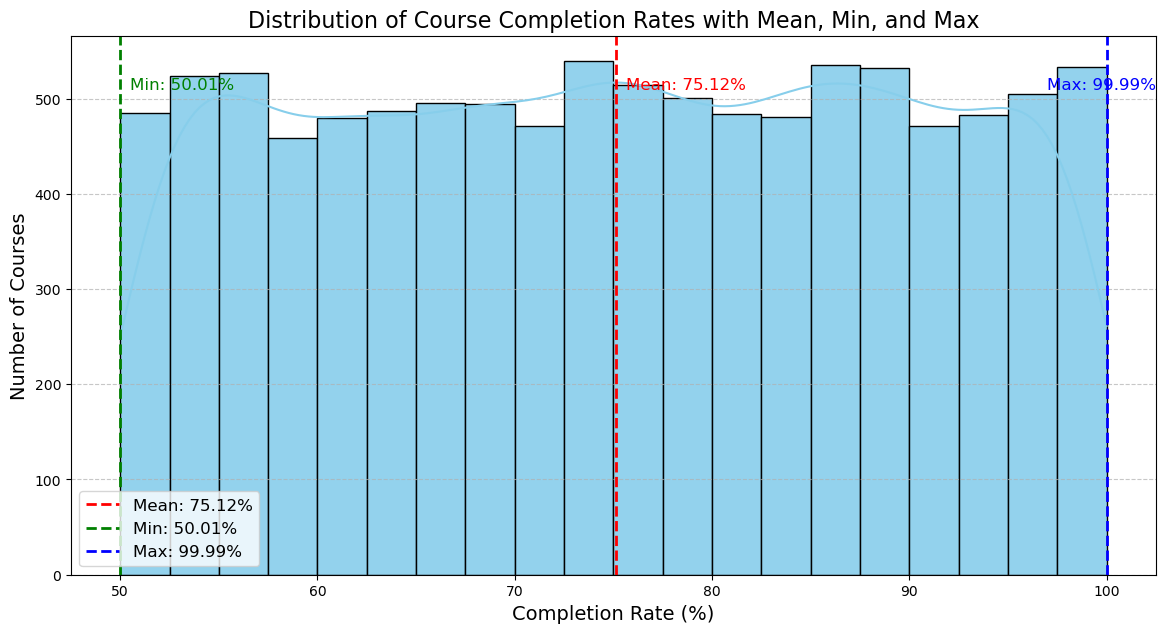

In [637]:
def plot_completion_rate_distribution(df, column_name='Completion_Rate (%)'):
    """
    Plot a histogram for the completion rate column with mean, min, and max indicated.
    """
    # Calculate the mean, minimum, and maximum of the column
    mean_value = df[column_name].mean()
    min_value = df[column_name].min()
    max_value = df[column_name].max()

    # Plot histogram
    plt.figure(figsize=(14, 7))  # Increase figure size
    sns.histplot(df[column_name], bins=20, kde=True, color='skyblue', edgecolor='black', alpha=0.9, linewidth=1)

    # Plot the mean, min, and max as vertical lines
    plt.axvline(mean_value, color='red', linestyle='--', linewidth=2, label=f'Mean: {mean_value:.2f}%')
    plt.axvline(min_value, color='green', linestyle='--', linewidth=2, label=f'Min: {min_value:.2f}%')
    plt.axvline(max_value, color='blue', linestyle='--', linewidth=2, label=f'Max: {max_value:.2f}%')

    # Annotate the mean, min, and max values on the plot
    plt.text(mean_value + 0.5, plt.gca().get_ylim()[1] * 0.9, f'Mean: {mean_value:.2f}%', color='red', fontsize=12)
    plt.text(min_value + 0.5, plt.gca().get_ylim()[1] * 0.9, f'Min: {min_value:.2f}%', color='green', fontsize=12)
    plt.text(max_value - 3, plt.gca().get_ylim()[1] * 0.9, f'Max: {max_value:.2f}%', color='blue', fontsize=12)

    #Add title, labels, and legend
    plt.title('Distribution of Course Completion Rates with Mean, Min, and Max', fontsize=16)
    plt.xlabel('Completion Rate (%)', fontsize=14)
    plt.ylabel('Number of Courses', fontsize=14)
    plt.legend(fontsize=12)

    #Customize the grid and axes
    plt.grid(axis='y', linestyle='--', alpha=0.7)

    # Save as PNG image
    plt.savefig("hist.png", dpi=300, bbox_inches='tight')
    # Show plot
    plt.show()

#call the function
plot_completion_rate_distribution(df)


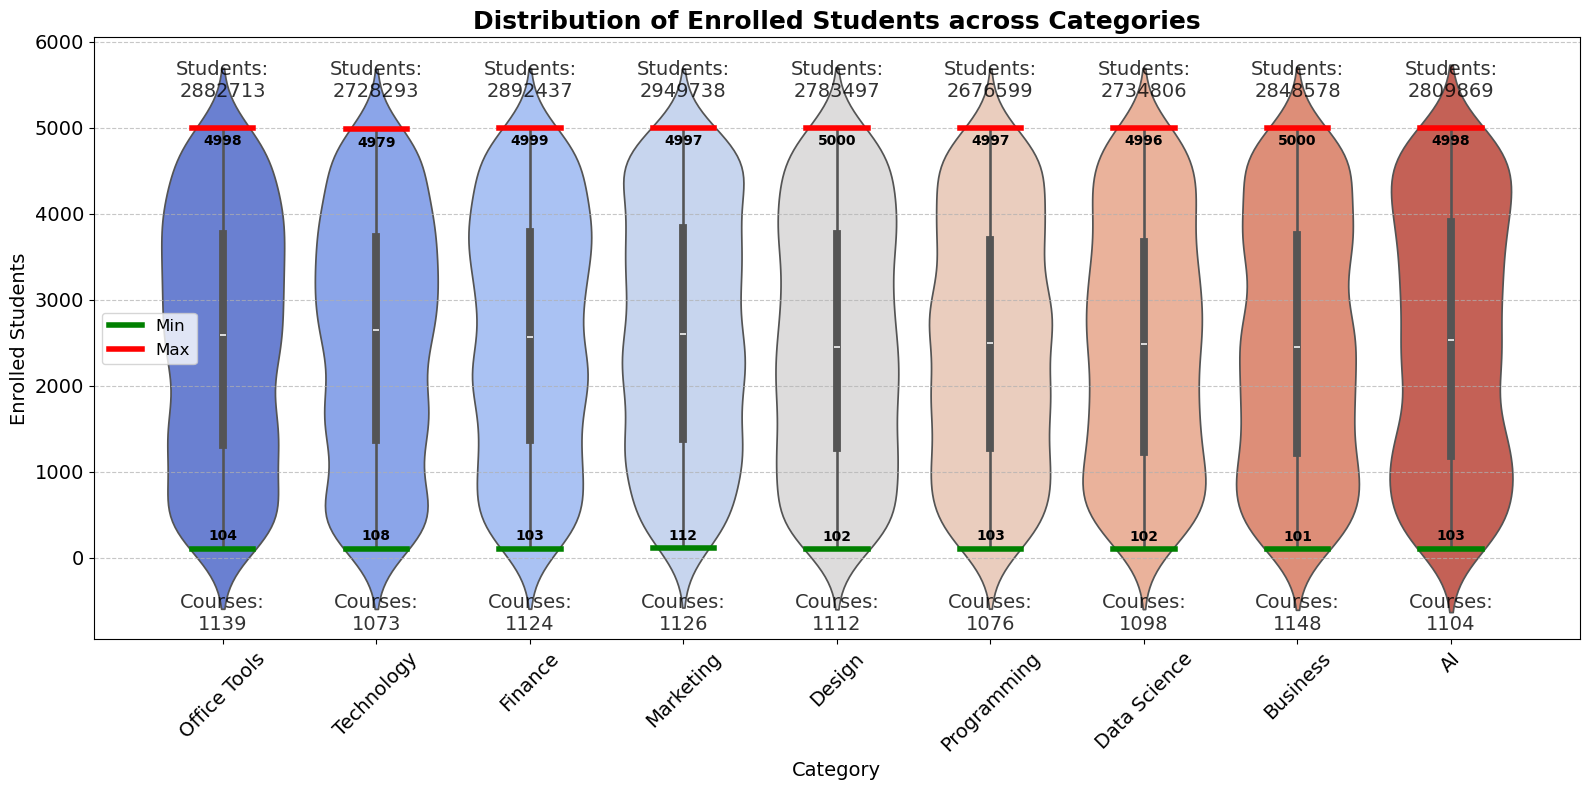

In [639]:

def plot_category_enrollment_distribution(df, category_col, enrollment_col):
    """
    Creates a violin plot for enrolled students across categories, with annotations for total enrolled students,
    course counts, and min/max enrollments.
    """
    #Calculate the total number of students enrolled in each category
    category_enrollment = df.groupby(category_col)[enrollment_col].sum()

    # Calculate the number of courses in each category
    category_count = df[category_col].value_counts()

    # Calculate the minimum and maximum enrollments for each category
    category_min = df.groupby(category_col)[enrollment_col].min()
    category_max = df.groupby(category_col)[enrollment_col].max()

    # Create a violin plot for Enrolled Students across Categories
    plt.figure(figsize=(16, 8))
    sns.violinplot(data=df, x=category_col, y=enrollment_col, hue=category_col, palette='coolwarm', legend=False)

    #the total number of enrolled students on top of each violin
    for i, category in enumerate(df[category_col].unique()):
        total_enrolled = category_enrollment[category]
        plt.text(i, df[enrollment_col].max() + 550, f'Students:\n{total_enrolled}',
                 horizontalalignment='center', fontsize=14, color='black', fontweight='normal',
                 verticalalignment='center', alpha=0.8)

    #the course count at the bottom of each category
    for i, category in enumerate(df[category_col].unique()):
        course_count = category_count[category]
        plt.text(i, -650, f'Courses:\n{course_count}',
                 horizontalalignment='center', fontsize=14, color='black', fontweight='normal',
                 verticalalignment='center', alpha=0.8)

    #Add the range(min and max) for each category
    for i, category in enumerate(df[category_col].unique()):
        min_enroll = category_min[category]
        max_enroll = category_max[category]

        # Add horizontal lines for the min and max values
        plt.plot([i - 0.2, i + 0.2], [min_enroll, min_enroll], color='green', linewidth=4, label='Min' if i == 0 else "")
        plt.plot([i - 0.2, i + 0.2], [max_enroll, max_enroll], color='red', linewidth=4, label='Max' if i == 0 else "")

        #Add the min and max text labels
        plt.text(i, min_enroll + 100, f'{min_enroll}', horizontalalignment='center', fontsize=10, color='black', weight='bold')
        plt.text(i, max_enroll - 200, f'{max_enroll}', horizontalalignment='center', fontsize=10, color='black', weight='bold')
        
    plt.legend(loc='center left', fontsize=12)
    plt.title('Distribution of Enrolled Students across Categories', fontsize=18, weight='bold')
    plt.xlabel('Category', fontsize=14)
    plt.ylabel('Enrolled Students', fontsize=14)
    plt.xticks(rotation=45, fontsize=14)
    plt.yticks(fontsize=14)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    # Save as PNG image
    plt.savefig("violin.png", dpi=300, bbox_inches='tight')
    # Show the plot
    plt.show()

#call the function
plot_category_enrollment_distribution(df, 'Category', 'Enrolled_Students')


Using curve_fit:
a = 4.40 +/- 2.34
b = 2082.90 +/- 291.11

Using numpy.polyfit:
a = 4.40 +/- 2.34
b = 2082.90 +/- 291.11


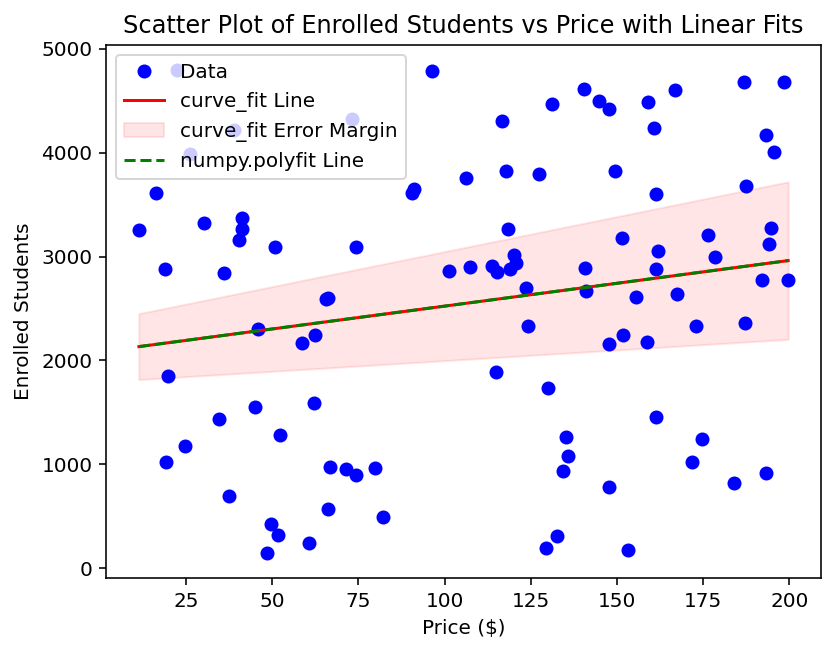

In [641]:
#get the data from dataset
y = df['Enrolled_Students'][:100].values
x = df['Price ($)'][:100].values 

# Define the linear function for fitting
def linfunc(x, a, b):
    """
    Function for fitting a straight line, for curve_fit.
    """
    return a * x + b

# Perform curve fitting
p, cov = curve_fit(linfunc, x, y)  #Fit linfunc to the data
sigma = np.sqrt(np.diag(cov))  #Errors are the square root of the diagonal of the covariance matrix

#Print curve_fit results
print(f"Using curve_fit:")
print(f"a = {p[0]:.2f} +/- {sigma[0]:.2f}")
print(f"b = {p[1]:.2f} +/- {sigma[1]:.2f}")

#Perform polynomial fitting
p_np = Poly.fit(x, y, 1)  # Fit a polynomial of degree 1
cov_np = np.polyfit(x, y, 1, cov=True)[1]  # Calculate covariance matrix separately
sigma_np = np.sqrt(np.diag(cov_np))
b, a = p_np.convert().coef  # Note: numpy provides coefficients in reverse order

#Print numpy.polyfit results
print(f"\nUsing numpy.polyfit:")
print(f"a = {a:.2f} +/- {sigma_np[0]:.2f}")
print(f"b = {b:.2f} +/- {sigma_np[1]:.2f}")

#Define a function for plotting
def plot_random_scatter_with_fitted_line(x, y):
    """
    Creates a scatter plot of data with a fitted line and error margins.
    """
    plt.figure(dpi=144)

    #Scatter plot
    plt.plot(x, y, 'bo', label="Data") 
    #Generate x values for the fitted line
    xfit = np.linspace(np.min(x), np.max(x), 1000) 

    #Fitted line from curve_fit
    plt.plot(xfit, linfunc(xfit, p[0], p[1]), 'r-', label="curve_fit Line")

    #Error margins for curve_fit
    plt.fill_between(
        xfit,
        linfunc(xfit, p[0] - sigma[0], p[1] - sigma[1]),
        linfunc(xfit, p[0] + sigma[0], p[1] + sigma[1]),
        color='r',
        alpha=0.1,
        label="curve_fit Error Margin"
    )

    #Fitted line from numpy.polyfit
    plt.plot(*p_np.linspace(), 'g--', label="numpy.polyfit Line")

    plt.xlabel('Price ($)')
    plt.ylabel('Enrolled Students')
    plt.title('Scatter Plot of Enrolled Students vs Price with Linear Fits')
    plt.legend()
    # Save as PNG image
    plt.savefig("linefit.png", dpi=300, bbox_inches='tight')
    plt.show()

# Call the plotting function
plot_random_scatter_with_fitted_line(x, y)


In [643]:
# Select relevant numerical columns
z = df[["Completion_Rate (%)", "Rating (out of 5)"]].values

#Normalize the data
scaler = RobustScaler()
norm = scaler.fit_transform(z)


2 clusters silhouette score = 0.35
3 clusters silhouette score = 0.38
4 clusters silhouette score = 0.40
5 clusters silhouette score = 0.39
6 clusters silhouette score = 0.38
7 clusters silhouette score = 0.37
8 clusters silhouette score = 0.36
9 clusters silhouette score = 0.37
10 clusters silhouette score = 0.37
Best number of clusters = 4


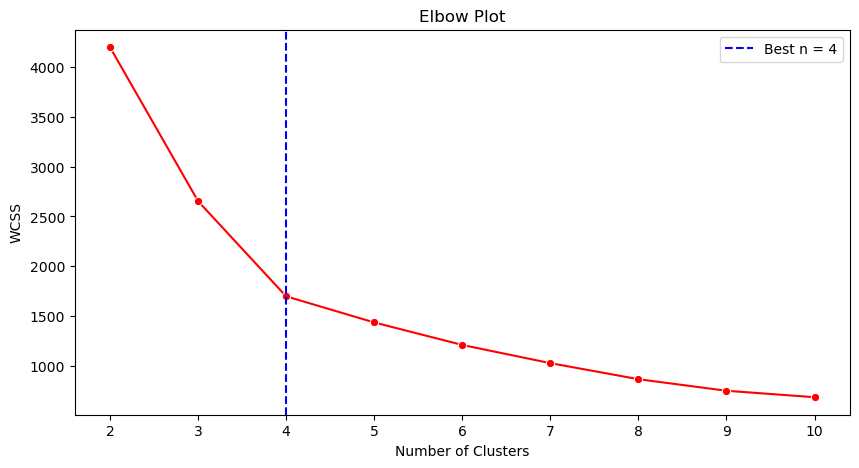

4

In [645]:
# Function to calculate silhouette score and WCSS for a given number of clusters
def calculate_silhouette_and_wcss(n_clusters, data):
    kmeans = KMeans(n_clusters=n_clusters, n_init=20, random_state=42)
    kmeans.fit(data)
    labels = kmeans.labels_
    score = silhouette_score(data, labels)
    inertia = kmeans.inertia_
    return score, inertia

#Function to find the best number of clusters and plot the elbow method
def find_best_clusters(data, cluster_range=(2, 11)):
    wcss = []
    best_n, best_score = None, -np.inf

    # Calculate silhouette score and WCSS for each number of clusters
    for n in range(cluster_range[0], cluster_range[1]):
        score, inertia = calculate_silhouette_and_wcss(n, data)
        wcss.append(inertia)
        if score > best_score:
            best_n = n
            best_score = score
        print(f"{n} clusters silhouette score = {score:.2f}")

    print(f"Best number of clusters = {best_n}")

    #Plot the Elbow Method
    plt.figure(figsize=(10, 5))
    sns.lineplot(x=range(cluster_range[0], cluster_range[1]), y=wcss, marker='o', color='red')
    plt.title('Elbow Plot')
    plt.xlabel('Number of Clusters')
    plt.ylabel('WCSS')
    plt.axvline(x=best_n, color='blue', linestyle='--', label=f'Best n = {best_n}')
    plt.legend()
    # Save as PNG image
    plt.savefig("Elbow.png", dpi=300, bbox_inches='tight')
    plt.show()

    return best_n

#call the function
find_best_clusters(norm)


In [649]:
def plot_clusters(xy, labels, xkmeans, ykmeans):
    unique_labels = np.unique(labels)
    #Custom colors for clusters
    colors = ['red', 'blue', 'green', 'purple']
    cluster_names = [f'Cluster {i+1}' for i in unique_labels]
    
    #Create a figure
    plt.figure(dpi=144, figsize=(8, 6))
    
    #Plot each cluster separately using sns.scatterplot
    for i, label in enumerate(unique_labels):
        sns.scatterplot(
            x=xy[labels == label, 0],
            y=xy[labels == label, 1],
            color=colors[i],
            label=cluster_names[i],
            s=50
        )
    
    #Plot centroids
    plt.scatter(
        xkmeans, ykmeans, 
        color='black', marker='X', s=200, label='Centroids', edgecolor='white'
    )
    
    #Annotate centroids
    for i, (x, y) in enumerate(zip(xkmeans, ykmeans)):
        plt.text(x, y, f"C{i+1}", fontsize=12, fontweight="bold", color="black", ha="center")
    
    plt.grid(True)
    plt.xlabel("Completion Rate (%)")
    plt.ylabel("Rating (out of 5)")
    plt.title("Cluster Visualization Completion Rate vs Rating with Centroids")
    plt.legend()
    
    # Show the plot
    # Save as PNG image
    plt.savefig("CLUSTER.png", dpi=300, bbox_inches='tight')
    plt.show()


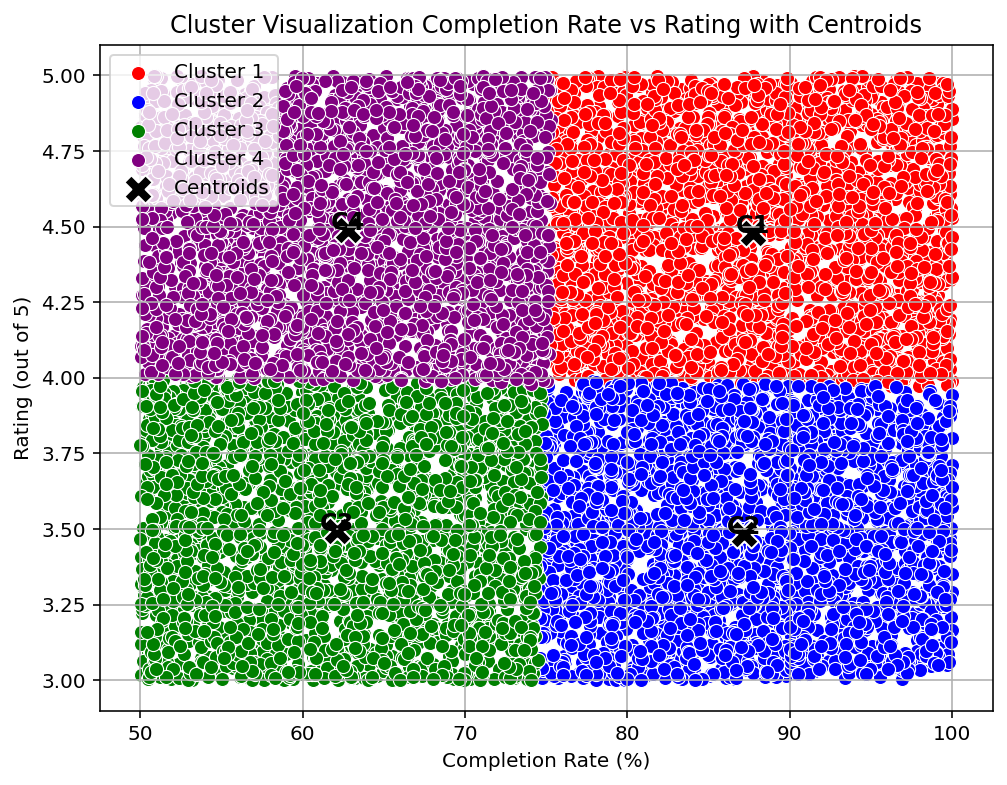

In [651]:
inv_norm = scaler.inverse_transform(norm)
plot_clusters(inv_norm, labels, xkmeans, ykmeans)